# Label and train notebook YOLO DS-ID

In [ ]:
# Set to true if on COLAB
USING_COLAB = False

In [ ]:
# If using google colab
if USING_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    import os
    # Set to the folder the repo was cloned
    os.chdir("/content/gdrive/MyDrive/Colab Notebooks/STRIKE_YOLO_DRIVE/STRIKE_YOLO")

In [ ]:
! pip install .

In [ ]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "yolo_type": "YOLOv0_E4_detect",
}

In [2]:
# Folders
# Location of images
images_folder = f"docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [3]:
# Path for sample image
n_image = 601
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [5]:
import os
import shutil
from pathlib import Path
import pandas as pd
from datetime import datetime
import scipy

from matplotlib import pyplot as plt

In [6]:
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils import plotting

# Load modules

In [ ]:
from pipelines.pipelines import ppl_label_YOLOv0, ppl_distribute_images_yolo
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import load_label
from helpers.aux_plotter import gaussians_labelled, plot_grayscale

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [15]:
# Load 400 gaussians
mat = scipy.io.loadmat("docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [16]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

# [ESTIMATION PART DS-ID]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_Yolo

### Image distribution

In [ ]:
"""
Image distribution for YoloV0
  - Images from 600 a 799
  - Labels without  gaussians with center out of the image
"""
range_images = list(range(600, 800))
proportions = {"train": 0.7, "val": 0.2, "test": 0.1}

if NOTEBOOK_CONFIG["label_mode"]:
    ppl_distribute_images_yolo(
        images_folder, labels_folder, yolo_folder, range_images, proportions
    )

In [ ]:
# Config Yolo model to train
yaml_content = f"""
                path: {os.path.join("..", model_folder)}
                train: {os.path.join("datasets/train/images")}
                val: {os.path.join("datasets/val/images")}
                test: {os.path.join("datasets/test/images")}
                names: ['gaussian']
                """

with open(os.path.join(model_folder, "data.yaml"), "w") as f:
    f.write(yaml_content)

### Training model - YOLOv0

In [ ]:
# Load nano model
model = YOLO("yolov8s.pt")  # "yolov8s-seg.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 158MB/s]


In [ ]:
# Train
model_name = "YOLOv0_E4_detect"
if NOTEBOOK_CONFIG["train_mode"]:
    results = model.train(
        device=0,  # "cpu"
        batch=-1,
        patience=100,
        task=NOTEBOOK_CONFIG["task"],
        data=os.path.join(model_folder, "data.yaml"),
        epochs=100,
    )

New https://pypi.org/project/ultralytics/8.0.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/data.yaml, epochs=100, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None,

In [ ]:
# Copy results (If in Google Colab)
if NOTEBOOK_CONFIG["train_mode"]:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    shutil.copytree(
        Path("/content/runs/"), Path(f"docs/Models/{model_name}/runs/{timestamp}")
    )

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E4_detect/runs/2023-08-21_14-37-58')

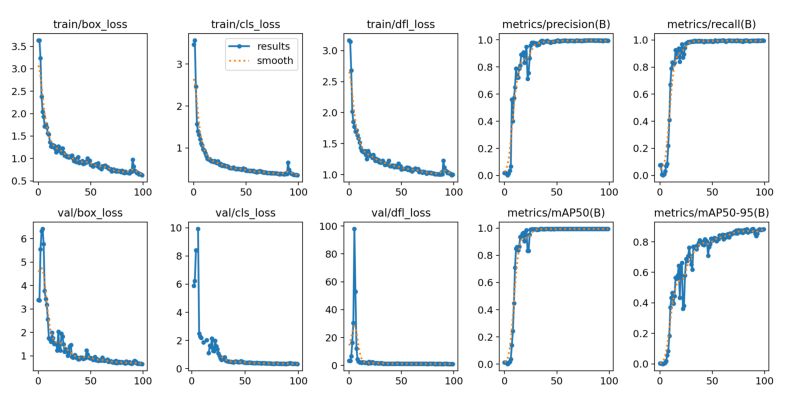

In [ ]:
# Plot results (if in Google Colab)
plotting.plot_results(f'/content/runs/{NOTEBOOK_CONFIG['task']}/train/results.csv')
image = Image.open(f'/content/runs/{NOTEBOOK_CONFIG['task']}/train/results.png')
fig = plt.figure(figsize = (10, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

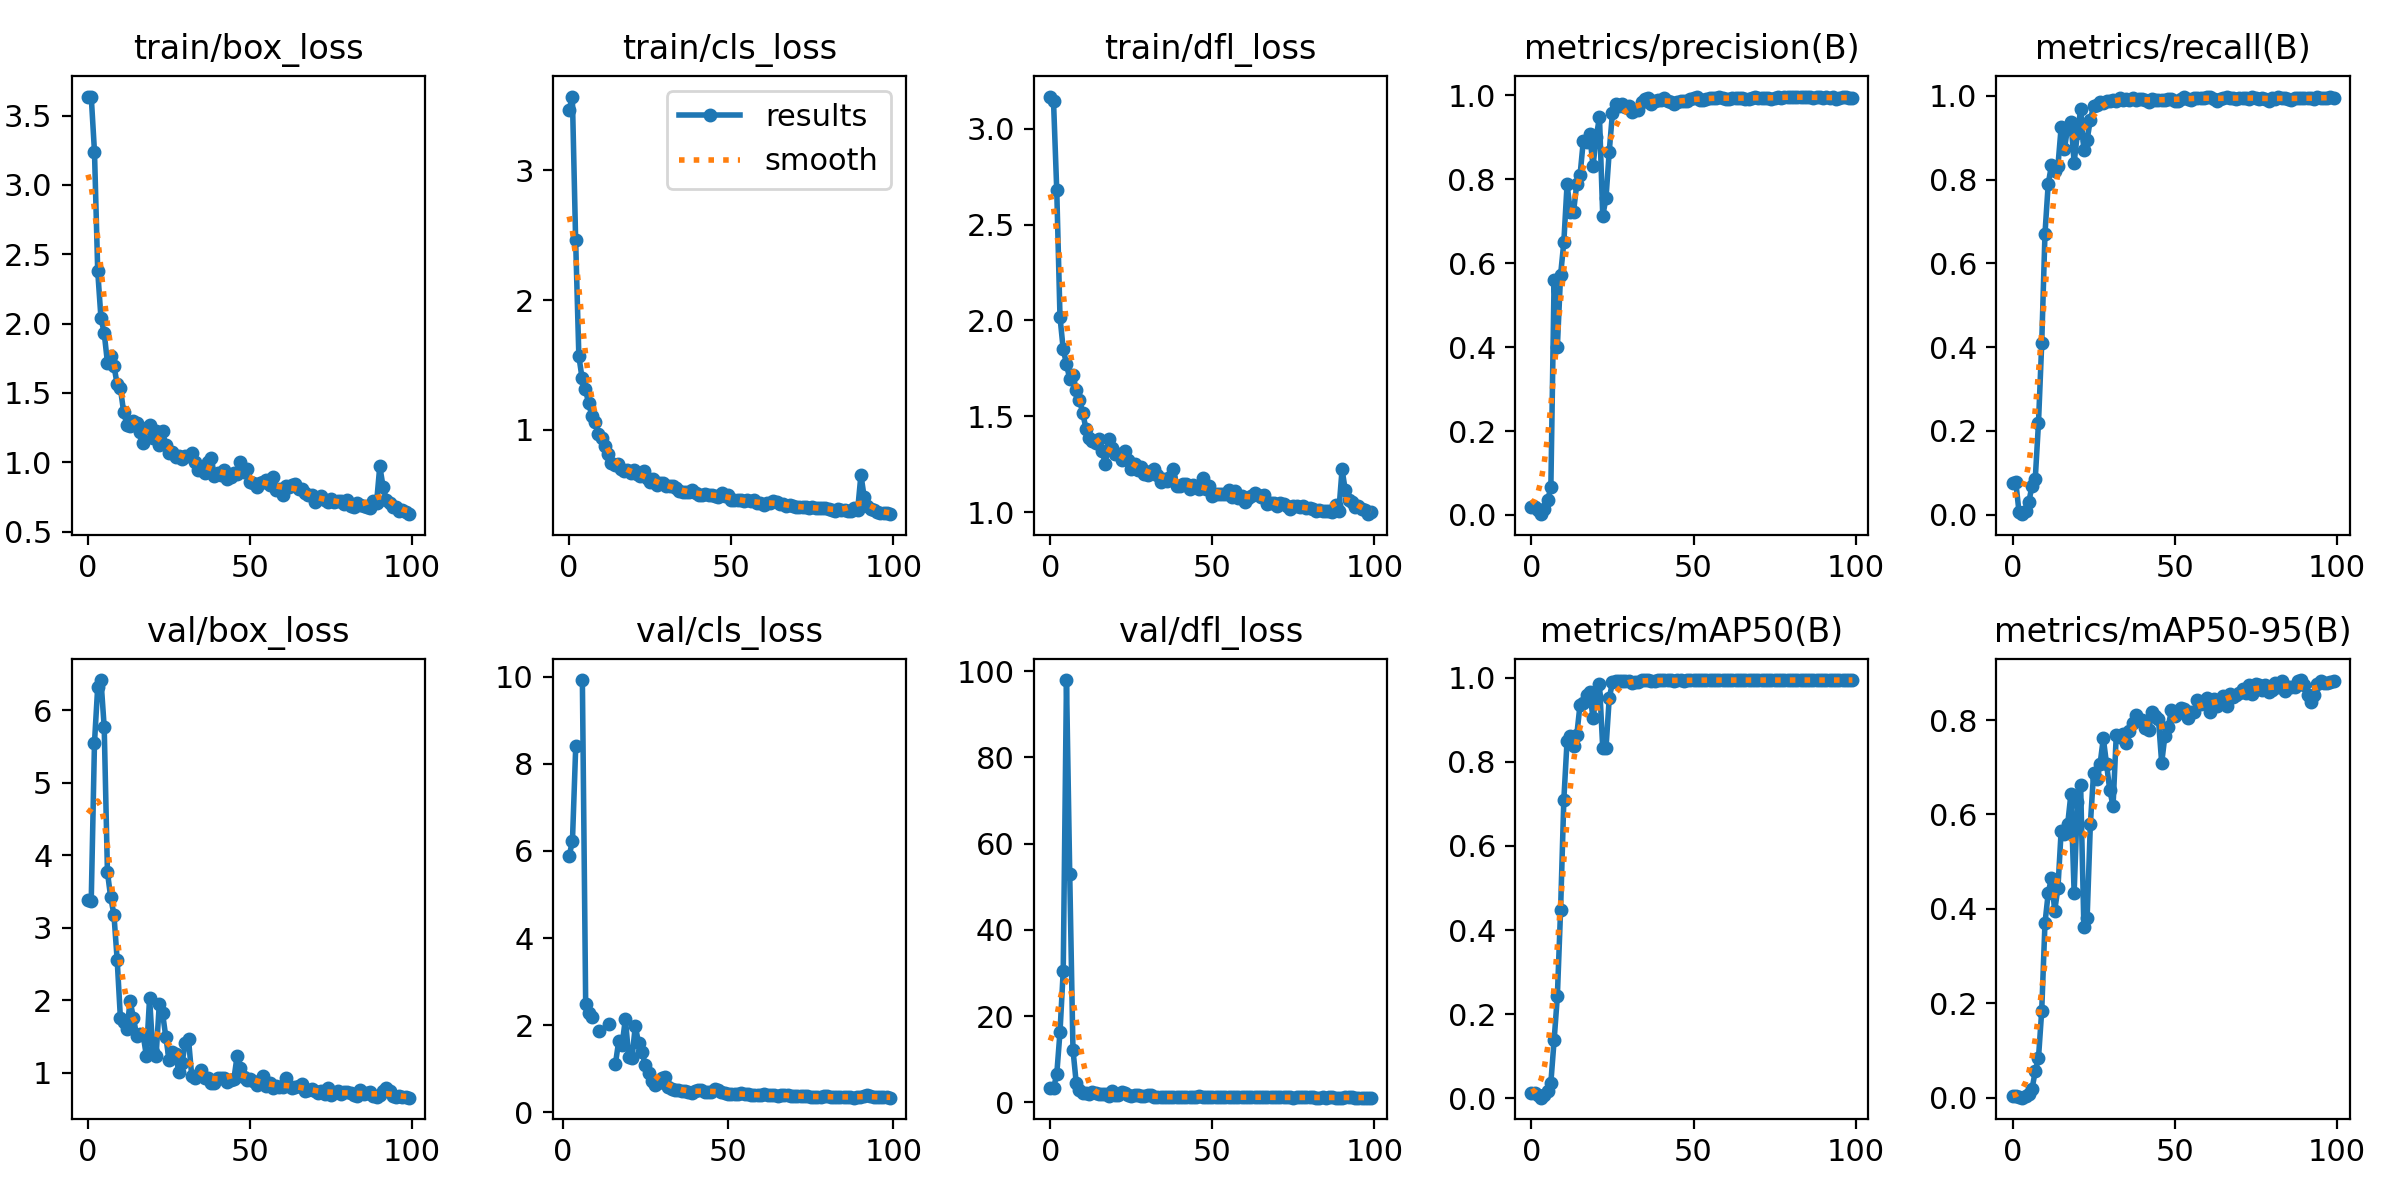

In [ ]:
image